# Finding the "needle in the haystack" galaxies¶
A python excersie notebook written by Lewis McMillan, Summer 2020. This notebook has benifited from examples provided by Rita Tojeiro, and the help of Anne-Marie Weijmans, and Simon Reynolds.

In this notebook you will use data from the Sloan Digital Sky Survey (SDSS), to explore how astronomers interact with "big data", and how they can use various different measurments of galaxies shapes in order to find spiral galaxies, the mergering of multiple galaxies, and other interesting galaxies.

## SDSS and SciServer
As mentioned above, in this notebook we will use data from SDSS, which is is the largest astronmical dataset in the world currently. For eachs nights observing it generates around 200Gb of data. The laptop this notebook was written on has 256Gb of storage space, meaning that I could fit 1 nights observing data on my laptop with some space left over for all the programs I need to analysie the data.

If you are reading this then we assume that you havel alredy followed the instructions to get an account on SciServer, and have uploaded this notebook. In addition to this we assume that you are familiar with basic python, dataframe manipulation, and matplotlib commands. If not please complete Rita Tojeiro's notebook's which cover these topics: link here

In [1]:
# move to correct folder
%cd ..
from pawlikMorphLSST import helpers, Image, pixmap, skyBackground, casgm # Library for analysing galaxies
print("Galaxy analysis code imported")
# move back to original folder
%cd -

# Import Python libraries to work with SciServer
import SciServer.CasJobs as CasJobs                 # query with CasJobs
import SciServer.SkyServer as SkyServer
print('SciServer libraries imported')

# Import other libraries for use in this notebook.
import numpy as np                                  # standard Python lib for math ops
import pandas as pd                                 # data manipulation package
import matplotlib.pyplot as plt                     # another graphing package
from pathlib import Path                            # manage local files in your Compute containers
from astropy.visualization import ZScaleInterval    # for plotting clear images
from tqdm import tqdm_notebook                      # for a nice progress bar
from concurrent.futures import ProcessPoolExecutor  # for running the code on more than 1 cpu
from IPython.display import clear_output            # allow nice printing
import json
print('Supporting libraries imported')

# Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pd.set_option('display.max_colwidth', -1)

# for plotting clear images
zscale = ZScaleInterval()

# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

/home/idies/workspace/Storage/0000_0002_7725_5162/persistent/outreach
Galaxy analysis code imported
/home/idies/workspace/Storage/0000_0002_7725_5162/persistent/outreach/notebooks
SciServer libraries imported
Supporting libraries imported
Settings applied


Lets load the results from the last notebook

In [2]:
# run this everytime you open the notebook to load in the results
finalResults = json.load(open("results.json"))
# convert dictionary to pandas dataframe
df = pd.DataFrame.from_dict(finalResults)
# print dataframe
df[:10]

,A,As,As90,C,S,g,m20,fname,radec
0,0.049226,0.128583,0.148649,3.278586,0.147236,0.554425,-2.023399,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz,"[27.475456237793, 13.1266326904297]"
1,0.029085,0.127824,0.172414,3.666046,0.128653,0.645667,-2.195161,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz,"[27.5298633575439, 13.1103744506836]"
2,0.059730,0.123932,0.170940,3.000422,0.157492,0.580669,-1.842354,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz,"[27.5653057098389, 13.140772819519]"
3,0.023338,0.215150,0.242483,3.110502,0.388009,0.563187,-1.855298,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0145.fit.gz,"[27.6536617279053, 13.1101999282837]"
4,0.038785,0.164304,0.388999,3.793418,0.154213,0.621341,-2.311551,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0146.fit.gz,"[27.8427829742432, 13.0603351593018]"
5,0.011948,0.140907,0.647154,3.404475,0.590916,0.467828,-2.005495,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/1/fpC-001035-r1-0147.fit.gz,"[27.8864421844482, 12.6996002197266]"
6,0.109114,0.167386,0.354185,3.535423,0.208361,0.534193,-0.977005,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/3/fpC-001035-r3-0147.fit.gz,"[28.0792255401611, 13.6340560913086]"
7,0.040494,0.077461,0.229446,3.177725,0.104522,0.640461,-2.094511,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0148.fit.gz,"[28.1850471496582, 13.1925506591797]"
8,0.041717,0.149702,0.459753,3.547808,0.342941,0.485550,-1.925784,/home/idies/workspace/sdss_das/das2/imaging/1043/40/corr/5/fpC-001043-r5-0185.fit.gz,"[28.3757038116455, 14.570948600769]"
9,0.047903,0.136556,0.172610,3.948916,0.111256,0.617453,-2.172213,/home/idies/workspace/sdss_das/das2/imaging/1043/40/corr/1/fpC-001043-r1-0186.fit.gz,"[28.4430923461914, 12.8804492950439]"


## Other measures of morphology
We saw in the last two notebooks how we can use the asymmetry parameters A, and As to get a sample of morphologically disturbed galaxies.
There are other measure of galaxy morphology. The above dataframe shows the different rows in the dataframe of results calculated using the full galaxy analysis code which include some other common measures of galaxy morphology:
- C: Is the Concentration of light within the galaxy
- S: Is is the Smoothnees/Clumpiness of the distribution of light in the galaxy.
- g: Is the Gini index of the galaxy.
- m20: Is the $2^{nd}$ moment of light of the galaxy

## Smoothness/Clumpiness, S
The smoothness parameter, as the name suggest, calculates how smooth the light distribution of a galaxy is. 

It calculates this by running a smoothing filter over the image and then subtracting this away from the original image. The code below show an example of this on the emoji example from before.

In [3]:
np.random.seed(1)
# Process emojis so that galaxy analysis code can analyse them
def preprocessEmoji(img):
    # convert image to grayscale
    emoji = color.rgb2gray(img)
    # shrink image so that code can process image in a timely manner
    emoji = transform.resize(emoji, (500, 500))
    # add some noise to image so that code can process the images as expected
    emoji += (1./25.) * np.random.standard_normal(size=(500, 500))
    return emoji

# Calculate the Smoothness/clumpiness parameter
def smoothDifference(img, kernel_size):
    import scipy.ndimage as ndi

    # smooth image
    smoothimg = ndi.uniform_filter(img, size=kernel_size)

    res = np.abs(img - smoothimg)
    return res

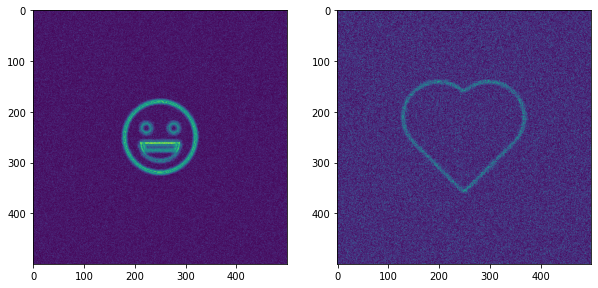

In [4]:
from skimage import io, color, transform
# read in the two emojis
smiley = io.imread("emoji-1.png")
heart = io.imread("emoji-2.png")

# preprocess emojis
smiley = preprocessEmoji(smiley)
heart = preprocessEmoji(heart)

# calculate smooth difference
smileySmooth = smoothDifference(smiley, 15)
heartSmooth = smoothDifference(heart, 15)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(smileySmooth)
ax[1].imshow(heartSmooth)

As you can see the smoothness parameter picks up the internal features of the smiley face, and the edges of both the emoji's. This makes this measurment ideal for finding galaxies where there are clumps of light caused by star forming regions in that galaxy.

## Concentration, C
The concentration parameter measures how concentrated the light is in a galaxy to its cores compared to its outer reaches.
This measure is usually calculated using a ratio of it radii. These radii are defined as the radii at which $n$% of light falls within. The code here uses 20% and 80% radii to calculate the concentration of light. The equation for this is shown below.

$C=5log_{10}\left(\frac{r_{80}}{r_{20}}\right)$

Below is an example of this calculation on the heart emoji. Note that the emoji has been faded for the purposes of this example.

In [5]:
def plotradii(ax, image, rmax, centroid, title):
    r20, r80 = casgm.calcR20_R80(image, centroid, rmax)
    # plot these circles
    circle1 = plt.Circle(centroid, r20, fill=False, color="red")
    circle2 = plt.Circle(centroid, r80, fill=False, color="black")
    ax.imshow(image)
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.set_title(title, fontsize=20)
    ax.legend([circle1, circle2], [f"R20={r20:.2f}", f"R80={r80:.2f}"], fontsize=15)
    # zoom in
    ax.set_xlim([100, 400])
    ax.set_ylim([400, 100])
    return r20, r80

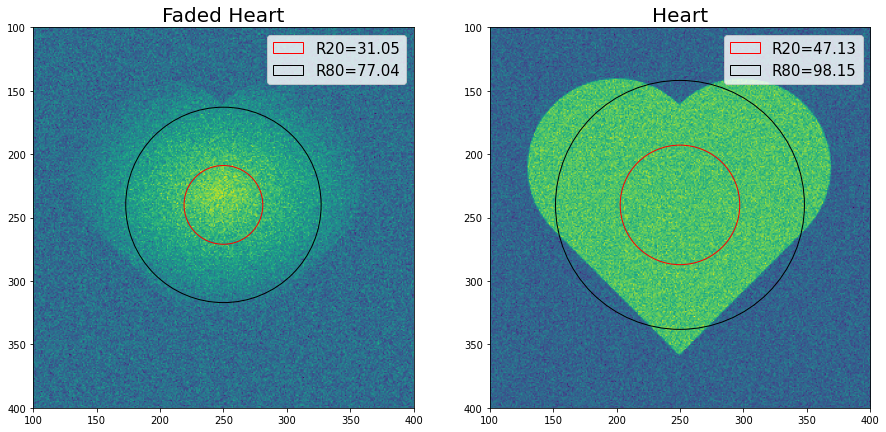

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# read in emoji
fheart = io.imread("emoji-3.png")

# preprocess emoji
fheart = preprocessEmoji(fheart)

# set maximum radius of emoji
rmax = 150
# set centre of emoji
centroid = [250, 240]
r20, r80 = plotradii(ax[0], fheart, rmax, centroid, "Faded Heart")

# set maximum radius of emoji
rmax = 190
# set centre of emoji
centroid = [250, 240]
r20, r80 = plotradii(ax[1], heart, rmax, centroid, "Heart")

## Excercise
1. Create a function that implments the Concentration formula. This function should take as its arguments, r20 and r80, and return the concentration
2. Use your function to calculate the concentration of the faded and normal heart emoji's. You will need to edit the above code slightly.

In [7]:
# Solution to Q1
def concentration(r20, r80):
    C = 5. * np.log10(r80 / r20)
    return C

Faded heart C=1.97
Normal heart C=1.59


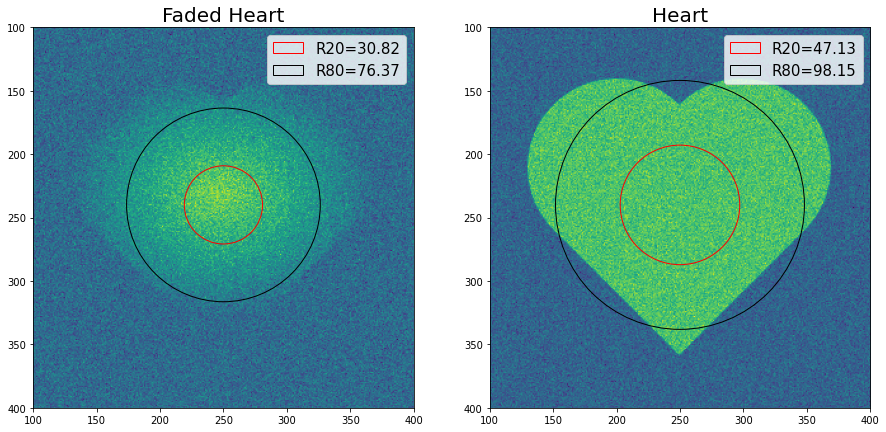

In [8]:
# Solution to Q2
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# read in emoji
fheart = io.imread("emoji-3.png")

# preprocess emoji
fheart = preprocessEmoji(fheart)

# set maximum radius of emoji
rmax = 150
# set centre of emoji
centroid = [250, 240]
fheartR20, fheartR80 = plotradii(ax[0], fheart, rmax, centroid, "Faded Heart") # student should edit

# set maximum radius of emoji
rmax = 190
# set centre of emoji
centroid = [250, 240]
heartR20, heartR80 = plotradii(ax[1], heart, rmax, centroid, "Heart") # student should edit

#student should print out C values for both emoji's
print(f"Faded heart C={concentration(fheartR20, fheartR80):.2f}")
print(f"Normal heart C={concentration(heartR20, heartR80):.2f}")

## Gini index
The Gini index is a bit more of an esotric measurment. It was orignally created to quantify a countires wealth inequality. An index of 0 represents a society where wealth is equally shared, and a index of 1 represents a society where one person has all the wealth.
The Gini index can be used to measure a galaxies distribution of light. We replace wealth with pixel values and use the same method to calculate the index.
The Gini index is calculated by calcuating the area between the curve of perfect equality (a straight line), and calculating the Lorenz curve for the galaxy.
The details of this  calculation are not important here.
Below is an example of the Gini index calculation for the two heart emoji's.

In [9]:
def Gini(v, ax, title):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    # generate cuvre for image
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    
    # calculate areas
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    # calculate Gini index
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    
    # plot everything
    ax.fill_between(bins, bins, yvals, alpha=0.5, label="Gini Index")
    ax.plot(bins, yvals, label="observed")
    ax.plot(bins, bins, '--', label="perfect eq.")
    ax.set_xlabel("fraction of pixels", fontsize=15)
    ax.set_ylabel("Total Flux", fontsize=15)
    ax.set_title(title + f" Gini: {gini_val:.4f}", fontsize=20)
    ax.legend(fontsize=15)

Warning! skyregion smaller than optimal 4585


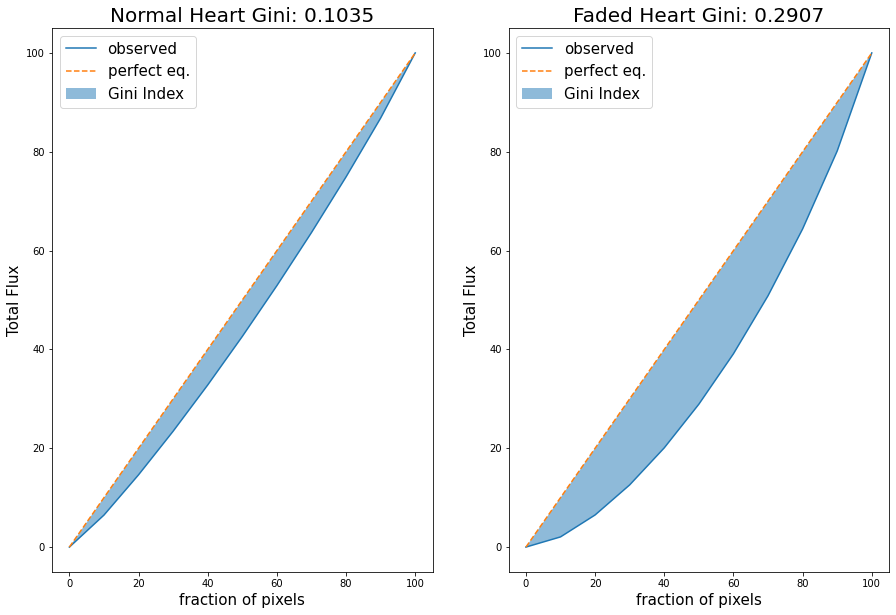

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

skybgr, skyerr, *rest = skyBackground.skybgr(heart)
heartmask = pixmap.pixelmap(heart, skybgr+skyerr, 3)
heart2D = heartmask * heart
heart1D = np.abs(heart2D[heart2D > 0])
Gini(heart1D, axs[0], "Normal Heart")

skybgr, skyerr, *rest = skyBackground.skybgr(fheart)
fheartmask = pixmap.pixelmap(fheart, skybgr+skyerr, 3)
heart2D = fheartmask * fheart
heart1D = np.abs(heart2D[heart2D > 0])
Gini(heart1D, axs[1], "Faded Heart")

As you probably expected, the example of the "normal" heart is more uniform as all its pixels were uniform. Where as the faded heart emoji has a range of pixel values, thus has a more inequal distirbution of pixel values.
The Gini index normally correlates with concentration. However, the Gini index can be used to find objects where the light is concentrated in a few pixels not at the centre of the galaxy.

## Exercise
1. It is expected that the Gini index for the "normal" heart emoji is exactly 0, why is this?
2. Why is it not exactly 0?
    
Possible solutions:
* Q1: It is expected to be exactly 0 as all the pixels in the image were equal before it was processed.
* Q2: It is not exactly 0 as an element of noise was added to the image to allow for the code to analyse it.

## $2^{nd}$ Moment of light, $M_{20}$
$M_{20}$ is defined as the normalised second moment of light of the brightest 20% of the galaxy's flux.

The second moment of light is defined as flux in each pixel, $f_i$, multiplied by the square of the distance to the centre of the galaxy, summed over all the pixels that belong to the galaxy. Therefore, to calculate $M_{20}$ we essentially take the top 20% pixels.

Again $M_{20}$ is similar to the cocentration, a a very negative value for $M_{20}$ indicates that there is high concentration of light in the Galaxy. However, in the calculation of $M_{20}$ the "centre" of the galaxy is a free parameter which is calculated to minimise the total $2^{nd}$ moment of light. Thus, for a really negative value of $M_{20}$ concentration of light may be anywhere in the galaxy.

Again we turn to the emoji's to illistrate this.

Text(0.5, 1.0, '$M_{20}$=-1.21')

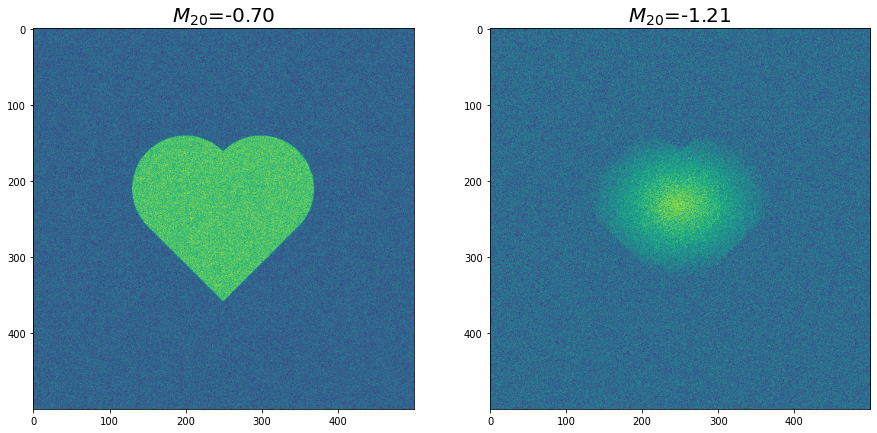

In [11]:
m20heart = casgm.m20(heart, heartmask)
m20fheart = casgm.m20(fheart, fheartmask)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs = axs.ravel()

axs[0].imshow(heart)
axs[0].set_title(fr"$M_{{20}}$={m20heart:.2f}", fontsize=20)

axs[1].imshow(fheart)
axs[1].set_title(fr"$M_{{20}}$={m20fheart:.2f}", fontsize=20)

As expected the faded heart has a more negative value of $M_{20}$, as there is a concentration of light near the centre of the heart. The normal heart in comparison does not highly negative $M_{20}$ as it has mostly uniform pixel values.

# Projects

Using the above morphology parameters and the asymmetry parameters you used before explore the data and try to generate samples where the majority of galaxies are:

* Merger Galaxies
* Spiral galaxies
* Ellipticals where a/b > 0.5
* Ellipticals where a$\approx$b, e.g spherical or near spherical galaxies
* Spiral galaxies with a bar

To asses if your sample has a majority of the correct type plot several and compute the statistics of the different types of galaxies. You make wish to adapt the code from the 1st notebook which plotted random galaxies on each run.
For each sample make sure you fully justify your use of the different morphology measures. You will need to make many plots to justify each sample, so make sure they are lablled correctly so that any one using your notebook to investigate these sampoles can understand your thinking.

You may wish to make use of the following source to help with creating these sample:
* [CJ. Conselice, 2014](https://arxiv.org/pdf/1403.2783.pdf)
* [M. Pawlik et al., 2016](https://academic.oup.com/mnras/article/456/3/3032/1103305)